# Data Wrangling

## Content
- [Import Necessary Packages](#import)
- [Test Data by Linear Regression](#test_data)
- [Data Extraction and Some Changes](#etl)
- [Data Quality Analysis](#dqa)
- [Additional Data Wranglings](#wrangling)
- [Four More Datasets for Potential Ensemble Model](#fourmore)

### Import Necessary Packages<a id = 'import'></a>

In [1]:
## Necessary packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pandas_profiling

from io import BytesIO
from zipfile import ZipFile
import urllib

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import sklearn.model_selection as m_sel

### Test Data by Linear Regression <a id = 'test_data'></a>

In [2]:
## Unzip and read file
url = urllib.request.urlopen('https://github.com/jonahwinninghoff/Springboard_Capstone_Project/raw/main/Assets/NH_QualityMsr_MDS_Jun2021.csv.zip')
file = ZipFile(BytesIO(url.read()))
qualitycsv = file.open("NH_QualityMsr_MDS_Jun2021.csv")
quality = pd.read_csv(qualitycsv, encoding='cp1252')
file.close()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
## Split data by 70 and 30
df = quality[['Provider Zip Code','Measure Code',
              'Four Quarter Average Score']].dropna(how = 'any', axis = 0)
dataset_X, dataset_y = df[['Provider Zip Code','Measure Code']], df['Four Quarter Average Score']
X_train, X_test, y_train, y_test = m_sel.train_test_split(dataset_X, dataset_y, 
                                                    test_size=0.20, 
                                                    random_state=666)

In [4]:
# Create 10 folds of cross validation and use linear regression
model = LinearRegression()
cv = m_sel.KFold(n_splits=10, random_state=444, shuffle=True)
print(model.fit(X_train, y_train))

LinearRegression()


In [5]:
# Create the 10 fold average metrics
thenames = ['Accuracy','Mean Absolute Error','Brier Score']
scorings = ['r2','neg_mean_absolute_error','neg_mean_squared_error']
scores = {}

for i in enumerate(thenames):
    scores[thenames[i[0]]] = m_sel.cross_val_score(model, 
                                                   X_train, y_train,
                                                   cv=cv, scoring=scorings[i[0]])
    scores[thenames[i[0]]] = np.absolute(round(np.mean(scores[thenames[i[0]]]),3))

In [6]:
print('The data problem that seems solvable is because the result is: '+str(scores)+
      ', even though both average MSE and average MAE is extremely high.')

The data problem that seems solvable is because the result is: {'Accuracy': 0.209, 'Mean Absolute Error': 26.53, 'Brier Score': 1053.954}, even though both average MSE and average MAE is extremely high.


### Data Extraction and Some Changes <a id = 'etl'></a>

In [7]:
display(quality.dtypes)

Federal Provider Number                      object
Provider Name                                object
Provider Address                             object
Provider City                                object
Provider State                               object
Provider Zip Code                             int64
Measure Code                                  int64
Measure Description                          object
Resident type                                object
Q1 Measure Score                            float64
Footnote for Q1 Measure Score               float64
Q2 Measure Score                            float64
Footnote for Q2 Measure Score               float64
Q3 Measure Score                            float64
Footnote for Q3 Measure Score               float64
Q4 Measure Score                            float64
Footnote for Q4 Measure Score               float64
Four Quarter Average Score                  float64
Footnote for Four Quarter Average Score     float64
Used in Qual

In [8]:
## Create easy and fast way to convert data types
def multi_astypes(data,string):
    diction = {}                              # Create empty dict
    thedict = {'o':'object', 'i':'int64', 'f':'float64', 
               'b':'bool', 'd':'datetime64', 't':'timedelta', 
               'c':'category'}
    thelist = list(string.lower())         # EX: obc -> [o,b,c]
    Error = 'Please use any letters of o, i, f, b, d, t, and c. Each letter represents the first letters of '+str(thedict)
    
    for i in range(0,len(thelist)):
        if thelist[i] in thedict:
            thetype = thedict[thelist[i]]# EX: thedict[o] -> object
            diction[data.columns[i]] = thetype
        else:
            raise ValueError(Error)
            break
        
    return data.astype(diction)            # Convert all columns

In [9]:
clean_quality = multi_astypes(quality,'oooociiocffffffffffcood') # Convert all data types

#### See what changes in data types

In [10]:
quality_dtypes = pd.DataFrame(quality.dtypes).reset_index()
clean_quality_dtypes = pd.DataFrame(clean_quality.dtypes).reset_index()

quality_dtypes.columns = ['variable', 'dtype']
clean_quality_dtypes.columns = ['variable', 'cleaned dtype']
comp = quality_dtypes.merge(clean_quality_dtypes, how = 'inner', 
                     on = 'variable')

comp['dtype'] = comp['dtype'].astype('str')
comp['cleaned dtype'] = comp['cleaned dtype'].astype('str')

display(comp[comp['dtype'] != comp['cleaned dtype']])

variable   dtype   cleaned dtype
4                             Provider State  object        category
8                              Resident type  object        category
19  Used in Quality Measure Five Star Rating  object        category
22                           Processing Date  object  datetime64[ns]

### Data Quality Analysis <a id='DQA'></a>

In [11]:
profile = pandas_profiling.ProfileReport(
    clean_quality, title="Data Quality Analysis")

In [12]:
display(profile)

Summarize dataset:   0%|          | 0/36 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
profile.to_file("your_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### Data Quality Analysis - Key Points:
- Federal Provider, Measure Period, and Processing Date have no value since those consist of single same duplications in each row.
- Each variable that contains "Footnote" has between 82.2% and 95.4% missing values.
- Each variable that contains "Measure Score" has between 10% and 17.8% missing values, and between 14.8% and 15.1% zeros.
- All measure scores are bimodally distributed. 


In [14]:
cleaned_df = clean_quality.drop(columns=['Federal Provider Number','Footnote for Q1 Measure Score',
                            'Footnote for Q2 Measure Score','Footnote for Q3 Measure Score',
                            'Footnote for Q4 Measure Score','Footnote for Four Quarter Average Score',
                            'Measure Period','Processing Date'])

### Additional Data Wranglings <a id='wrangling'></a>

#### Check duplications

In [15]:
result = any(cleaned_df.duplicated())

if result == False:
    print('There is none of duplications existed in data')
else:
    cleaned_df[cleaned_df.duplicated()]

There is none of duplications existed in data


### Save Guam and Puerto Rico in subset

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

subset = ['PR','GU']

def vectorize_df(data, column, stop_words = None, max_df = 1, min_df = 1):
    
    # Use TfidVectorizer to vectorize selected column
    vectorizer = TfidfVectorizer(stop_words = stop_words, max_df = max_df, min_df = min_df)
    vectorized_array = vectorizer.fit_transform(data[column]).toarray()
    names_list = vectorizer.get_feature_names()
    
    # Datafy vectorized matrix and create empty dictionary list
    df = pd.DataFrame(vectorized_array.tolist())
    columns_renamed = {}
    
    # Automate to replace all column names
    for i in enumerate(names_list):
        columns_renamed[i[0]] = i[1]
    df = df.rename(columns = columns_renamed)
    
    # Merge data with df
    the_data = data.merge(df, left_index = True,
                              right_index = True,
                              how = 'inner')
    
    return the_data

q_selected = cleaned_df[['Four Quarter Average Score','Measure Description']]

# Vectorize and Drop Measure Description
cleaned_q = vectorize_df(q_selected,'Measure Description', stop_words = 'english', 
                         max_df = 0.8, min_df = 2).drop('Measure Description', axis = 1)

In [17]:
from sklearn.decomposition import PCA
df = pd.concat([cleaned_q.iloc[:,0],cleaned_df['Provider State'],
           pd.DataFrame(PCA(n_components = 18).fit_transform(cleaned_q.iloc[:,1:]))],axis=1)

prgu = df[df['Provider State'].isin(subset)].dropna(axis=0)

In [18]:
prgu.to_csv('PCA_with_Guam_and_Puerto_Rico')

#### What if measure scores remove all missing values and zeros?

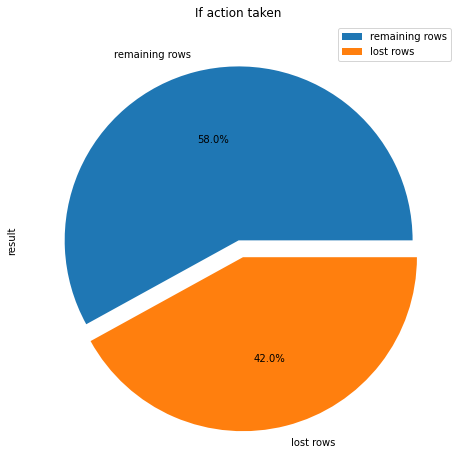

In [19]:
## Copy the data for experiment
guinea_pig = cleaned_df.copy()

guinea_pig = guinea_pig.dropna(how = 'any', axis = 0)    # Drop all NaN in every row
guinea_pig = guinea_pig[~(guinea_pig==0.0).any(          # Drop all zeros in every row
    axis = 1)]

# The result is:
pie_chart = pd.DataFrame({"result":[len(guinea_pig),len(cleaned_df)-len(guinea_pig)]},
                        index = ['remaining rows', 'lost rows'])

pie_chart.plot.pie(y='result', figsize=(8, 8), autopct='%1.1f%%', explode=(0, 0.1), title = 'If action taken')
plt.show()

#### What if average measure score alone remove all missing values and zeros?

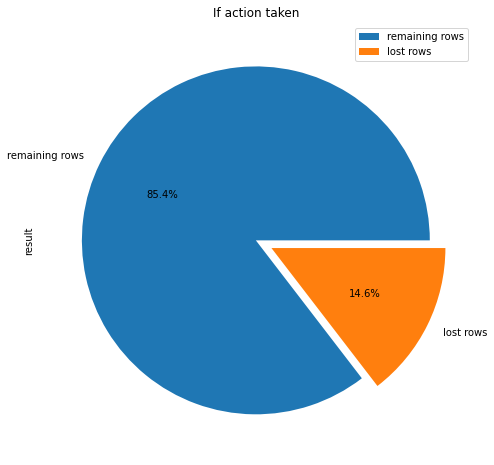

In [20]:
## Copy the dataframe for second experiment
guinea_pig = cleaned_df.copy()

guinea_pig = guinea_pig[guinea_pig['Four Quarter Average Score'].notnull()]  # Remove NaN only in one column
guinea_pig = guinea_pig[guinea_pig['Four Quarter Average Score'] != 0]       # Remove zeros only in one column


# The result is:
pie_chart = pd.DataFrame({"result":[len(guinea_pig),len(cleaned_df)-len(guinea_pig)]},
                        index = ['remaining rows', 'lost rows'])

pie_chart.plot.pie(y='result', figsize=(8, 8), autopct='%1.1f%%', explode=(0, 0.1), title = 'If action taken')
plt.show()

#### The latter course of action is chosen

In [21]:
average_df = cleaned_df[cleaned_df['Four Quarter Average Score'].notnull()]
average_df = cleaned_df[cleaned_df['Four Quarter Average Score'] != 0]

#### Check if measure scores are different in each state

In [22]:
melted_df = average_df.melt(id_vars = ['Provider Name', 'Provider Address', 'Provider City', 'Provider State',
                           'Provider Zip Code', 'Measure Code', 'Measure Description',
                           'Resident type','Used in Quality Measure Five Star Rating', 
                           'Location'],
                value_vars =['Q1 Measure Score', 'Q2 Measure Score','Q3 Measure Score', 
                             'Q4 Measure Score','Four Quarter Average Score'],
                var_name ='Type of MS', value_name ='MS')

threshold = melted_df['MS'].agg('median')

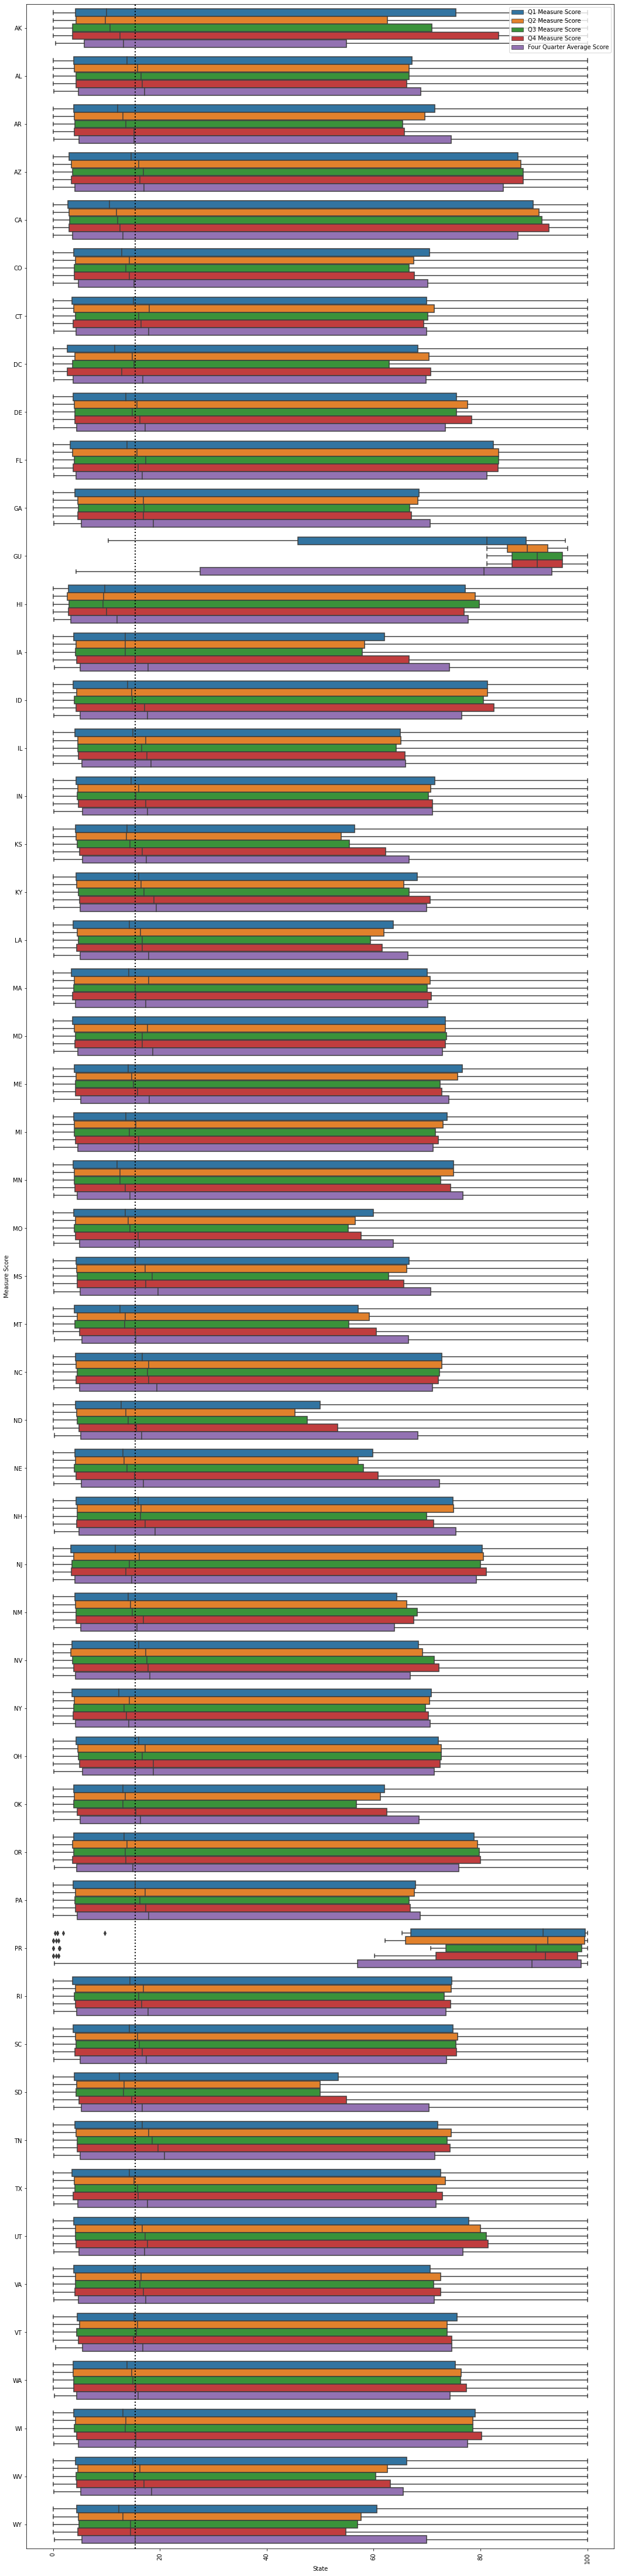

In [23]:
plt.subplots(figsize=(18, 80))
sns.boxplot(y='Provider State', x='MS', hue='Type of MS', data=melted_df,orient="h")
plt.xticks(rotation='vertical')
plt.axvline(x=threshold,linewidth=2, color='black',linestyle=':')
plt.legend( loc = 'upper right')
plt.ylabel('Measure Score')
plt.xlabel('State')
plt.show()

In [24]:
## Remove GU and PR due to skewed scores
average_df = average_df[~average_df['Provider State'].isin(['GU','PR'])]

#### Difference between Y and N in 'Used in Quality Measure Five Star Rating'

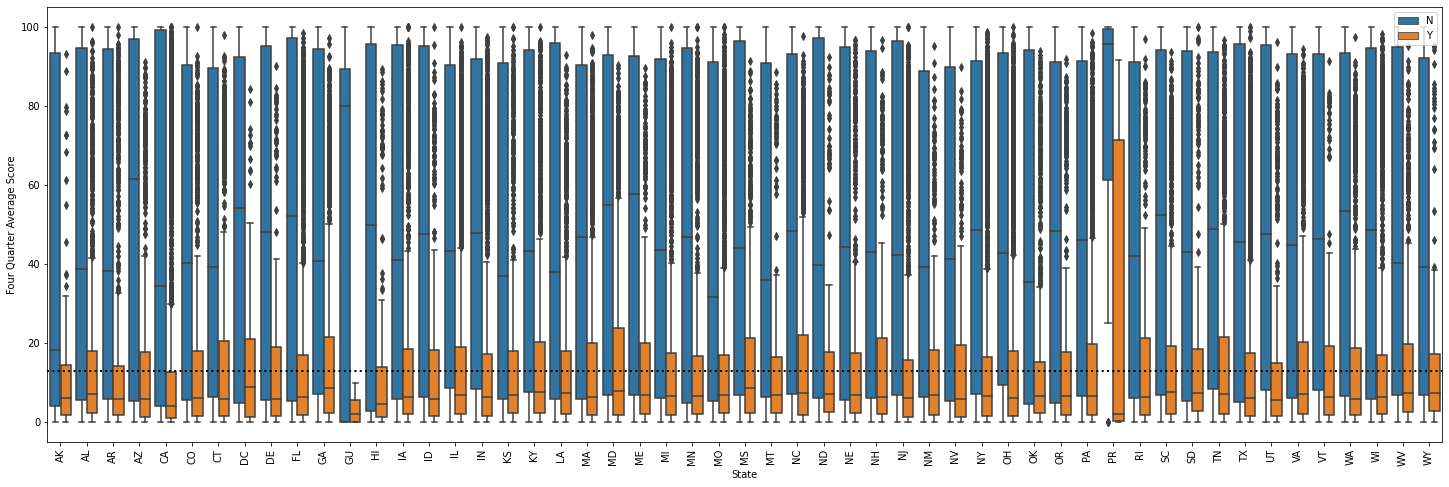

In [25]:
plt.subplots(figsize=(25, 8))
sns.boxplot(x='Provider State', y='Four Quarter Average Score', hue='Used in Quality Measure Five Star Rating', data=cleaned_df,orient="v")
plt.xticks(rotation='vertical')
plt.axhline(y=cleaned_df['Four Quarter Average Score'].agg('median'),linewidth=2, color='black',linestyle=':')
plt.legend( loc = 'upper right')
plt.ylabel('Four Quarter Average Score')
plt.xlabel('State')
plt.show()

In [26]:
average_df.to_json("neat_average_score_data")

### Four More Datasets for Ensemble Model <a id="fourmore"></a>

In [27]:
## Remove Guam and Puerto Rico
cleaned_df = cleaned_df[~cleaned_df['Provider State'].isin(['GU','PR'])]

In [28]:
## Copy cleaned dataframe
q1_df = cleaned_df.copy()
q2_df = cleaned_df.copy()
q3_df = cleaned_df.copy()
q4_df = cleaned_df.copy()

## Remove NaN in Q1
q1_df = q1_df[q1_df['Q1 Measure Score'].notnull()]
q1_df = q1_df[q1_df['Q1 Measure Score'] != 0]

## Remove NaN in Q2
q2_df = q2_df[q2_df['Q2 Measure Score'].notnull()]
q2_df = q2_df[q2_df['Q2 Measure Score'] != 0]

## Remove NaN in Q3
q3_df = q3_df[q3_df['Q3 Measure Score'].notnull()]
q3_df = q3_df[q3_df['Q3 Measure Score'] != 0]

## Remove NaN in Q4
q4_df = q4_df[q4_df['Q4 Measure Score'].notnull()]
q4_df = q4_df[q4_df['Q4 Measure Score'] != 0]

In [29]:
# Save four datasets
q1_df.to_json("neat_Q1_score_data")
q2_df.to_json("neat_Q2_score_data")
q3_df.to_json("neat_Q3_score_data")
q4_df.to_json("neat_Q4_score_data")